# Question and Answer Bahasa Indonesia dengan LSTM

##Pendahuluan

Proyek ini bertujuan untuk membangun sistem Question and Answer (QA) menggunakan model Recurrent Neural Network (RNN) dengan arsitektur Long Short-Term Memory (LSTM) untuk bahasa Indonesia. Sistem ini akan dilatih untuk memahami konteks teks dan menemukan jawaban yang relevan dari konteks tersebut berdasarkan pertanyaan yang diberikan. Fokus utama adalah pada dataset IndoQA, dengan implementasi langkah-langkah preprocessing data, pembangunan model LSTM, serta evaluasi performa model untuk tugas QA berbasis ekstrak.

## Instalasi, Impor Library, dan Memuat Dataset

Pada bagian ini kami menginstal library yang dibutuhkan, mengimpor library tersebut ke dalam notebook, dan memuat dataset IndoQA dari Hugging Face.

In [ ]:
# Instalasi library yang dibutuhkan
!pip install datasets==2.19.1 tensorflow numpy

# Impor library
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from datasets import load_dataset
import numpy as np
import json

# Memuat dataset dari Hugging Face
try:
    dataset = load_dataset("jakartaresearch/indoqa")
except Exception as e:
    print(f"Gagal memuat dataset. Error: {e}")
    # Fallback jika ada masalah koneksi, dengan membuat dummy dataset
    data_files = {
        "train": "https://huggingface.co/datasets/jakartaresearch/indoqa/resolve/main/data/train.json",
        "validation": "https://huggingface.co/datasets/jakartaresearch/indoqa/resolve/main/data/validation.json"
    }
    dataset = load_dataset("json", data_files=data_files)


# Menampilkan informasi dasar tentang dataset
print("Struktur Dataset:")
print(dataset)

# Menampilkan satu contoh data dari split 'train'
print("\nContoh Data:")
print(json.dumps(dataset['train'][0], indent=2, ensure_ascii=False))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 8.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.3.1 which is incompatible.


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/3309 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1104 [00:00<?, ? examples/s]

Struktur Dataset:
DatasetDict({
    train: Dataset({
        features: ['id', 'context', 'question', 'answer', 'category', 'span_start', 'span_end'],
        num_rows: 3309
    })
    validation: Dataset({
        features: ['id', 'context', 'question', 'answer', 'category', 'span_start', 'span_end'],
        num_rows: 1104
    })
})

Contoh Data:
{
  "id": "629HsNl5Qf3THUq_CbmFrSx28",
  "context": "Para pemuda pejuang, termasuk Chaerul Saleh, Sukarni, dan Wikana yang terbakar gelora kepahlawanannya setelah berdiskusi dengan Ibrahim gelar Datuk Tan Malaka. Pada dini hari tanggal 16 Agustus 1945, mereka bersama Shodanco Singgih, salah seorang anggota PETA, dan pemuda lain, membawa Soekarno (bersama Fatmawati dan Guntur yang baru berusia 9 bulan) serta Hatta, ke Rengasdengklok, yang kemudian terkenal sebagai Peristiwa Rengasdengklok. Tujuannya adalah agar Soekarno dan Hatta tidak terpengaruh oleh Jepang. Di sini, mereka kembali meyakinkan Soekarno bahwa Jepang telah menyerah dan para pej

## Validasi dan Pembersihan Data Awal

Tujuan dari sel ini adalah untuk memastikan setiap baris data yang akan kita gunakan adalah valid. Kita akan melakukan dua pengecekan krusial:
- Memastikan bahwa `span_start` dan `span_end` yang diberikan benar-benar menghasilkan teks `answer` jika kita potong (slice) dari `context`.
- Menghapus data di mana `span_start` adalah -1, yang menandakan jawaban tidak dapat ditemukan di dalam `context`.

Dengan melakukan ini di awal, kita memastikan bahwa semua data yang lolos ke tahap tokenisasi adalah data yang "bersih" dan berkualitas.

In [ ]:
import pandas as pd

def validate_and_clean_data(dataset_split):
    """
    Fungsi untuk memvalidasi dan membersihkan data.
    - Memastikan span start & end cocok dengan answer.
    - Menghapus data dengan span_start = -1.
    """
    # Konversi ke pandas DataFrame untuk kemudahan manipulasi
    df = pd.DataFrame(dataset_split)

    # Filter 1: Hapus data yang tidak memiliki jawaban (span_start == -1)
    initial_rows = len(df)
    df = df[df['span_start'] != -1].copy()
    rows_after_filter1 = len(df)
    print(f"Filter 1: Menghapus data tanpa jawaban. Ditemukan dan dihapus: {initial_rows - rows_after_filter1} baris.")

    # Filter 2: Verifikasi kecocokan span dengan jawaban
    def verify_span(row):
        # Ambil teks jawaban berdasarkan span dari konteks
        extracted_text = row['context'][row['span_start']:row['span_end']]
        # Bandingkan dengan teks jawaban asli (setelah normalisasi spasi)
        return " ".join(extracted_text.split()) == " ".join(row['answer'].split())

    is_valid_span = df.apply(verify_span, axis=1)

    rows_before_filter2 = len(df)
    df = df[is_valid_span]
    rows_after_filter2 = len(df)
    print(f"Filter 2: Memverifikasi span karakter. Ditemukan dan dihapus data yang tidak cocok: {rows_before_filter2 - rows_after_filter2} baris.")

    # Konversi kembali ke format list of dictionaries
    cleaned_data = df.to_dict(orient='records')
    return cleaned_data

# Jalankan pembersihan pada data training dan validasi
print("--- Memvalidasi Training Data ---")
cleaned_train_data = validate_and_clean_data(dataset['train'])
print(f"Jumlah data training setelah dibersihkan: {len(cleaned_train_data)}")

print("\n--- Memvalidasi Validation Data ---")
cleaned_val_data = validate_and_clean_data(dataset['validation'])
print(f"Jumlah data validasi setelah dibersihkan: {len(cleaned_val_data)}")

# -- Pengecekan Hasil --
print("\n--- Pengecekan Hasil Pembersihan ---")
# Cek apakah masih ada data setelah dibersihkan
if cleaned_train_data and cleaned_val_data:
    print("Pembersihan data berhasil.")
    print("Contoh data pertama setelah dibersihkan:")
    print(json.dumps(cleaned_train_data[0], indent=2, ensure_ascii=False))
else:
    print("Peringatan: Tidak ada data yang tersisa setelah pembersihan!")

--- Memvalidasi Training Data ---
Filter 1: Menghapus data tanpa jawaban. Ditemukan dan dihapus: 60 baris.
Filter 2: Memverifikasi span karakter. Ditemukan dan dihapus data yang tidak cocok: 174 baris.
Jumlah data training setelah dibersihkan: 3075

--- Memvalidasi Validation Data ---
Filter 1: Menghapus data tanpa jawaban. Ditemukan dan dihapus: 20 baris.
Filter 2: Memverifikasi span karakter. Ditemukan dan dihapus data yang tidak cocok: 45 baris.
Jumlah data validasi setelah dibersihkan: 1039

--- Pengecekan Hasil Pembersihan ---
Pembersihan data berhasil.
Contoh data pertama setelah dibersihkan:
{
  "id": "629HsNl5Qf3THUq_CbmFrSx28",
  "context": "Para pemuda pejuang, termasuk Chaerul Saleh, Sukarni, dan Wikana yang terbakar gelora kepahlawanannya setelah berdiskusi dengan Ibrahim gelar Datuk Tan Malaka. Pada dini hari tanggal 16 Agustus 1945, mereka bersama Shodanco Singgih, salah seorang anggota PETA, dan pemuda lain, membawa Soekarno (bersama Fatmawati dan Guntur yang baru berusi

## Membangun Kosakata dengan Tokenizer

Di sel ini, tugas kita fokus pada satu hal: menganalisis semua teks yang bersih dan membuat kamus kata-ke-angka. Kita akan menggunakan `Tokenizer` dari `Keras` untuk melakukan ini secara otomatis. Proses ini akan menjadi dasar untuk mengubah semua teks kita menjadi sekuens numerik di sel berikutnya.

In [ ]:
# -- Hyperparameters untuk Tokenisasi --
VOCAB_SIZE = 10000  # Ukuran kosakata (jumlah kata unik yang akan dipertimbangkan)
OOV_TOKEN = "<unk>" # Token untuk kata-kata di luar kosakata (Out-of-Vocabulary)

# 1. Kumpulkan semua teks dari data yang sudah bersih
# Kita hanya perlu teks dari 'context' dan 'question'
all_texts = [d['context'] for d in cleaned_train_data] + \
            [d['question'] for d in cleaned_train_data] + \
            [d['context'] for d in cleaned_val_data] + \
            [d['question'] for d in cleaned_val_data]

# 2. Inisialisasi dan "fit" tokenizer pada semua teks
# Proses ini akan membangun indeks kata (word_index)
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(all_texts)

# -- Pengecekan Hasil --
word_count = len(tokenizer.word_index)
print(f"Tokenizer berhasil dibuat.")
print(f"Total kata unik yang ditemukan: {word_count}")
print(f"Ukuran kosakata yang akan digunakan (VOCAB_SIZE): {VOCAB_SIZE}")

# Tampilkan beberapa kata yang paling umum
print("\nContoh 10 kata paling umum:")
# word_counts adalah dictionary {kata: frekuensi}
# Kita urutkan berdasarkan frekuensi dan ambil 10 teratas
top_10_words = sorted(tokenizer.word_counts.items(), key=lambda item: item[1], reverse=True)[:10]
for word, count in top_10_words:
    print(f"- {word}: {count} kali")

# Tampilkan indeks untuk beberapa kata kunci
print("\nContoh indeks kata:")
print(f"Indeks untuk kata 'indonesia': {tokenizer.word_index.get('indonesia')}")
print(f"Indeks untuk kata 'siapa': {tokenizer.word_index.get('siapa')}")
print(f"Indeks untuk OOV token '<unk>': {tokenizer.word_index.get(OOV_TOKEN)}")

Tokenizer berhasil dibuat.
Total kata unik yang ditemukan: 15031
Ukuran kosakata yang akan digunakan (VOCAB_SIZE): 10000

Contoh 10 kata paling umum:
- dan: 11450 kali
- yang: 11048 kali
- di: 8611 kali
- pada: 6423 kali
- dari: 4259 kali
- dengan: 4027 kali
- untuk: 2985 kali
- dalam: 2875 kali
- tahun: 2823 kali
- ini: 2799 kali

Contoh indeks kata:
Indeks untuk kata 'indonesia': 12
Indeks untuk kata 'siapa': 140
Indeks untuk OOV token '<unk>': 1


## Tokenisasi, Konversi Span, dan Padding

Di sel ini, kita akan melakukan tiga tugas utama:
- Tokenisasi: Mengubah setiap kalimat (konteks dan pertanyaan) dari data yang sudah bersih menjadi urutan angka (integer) menggunakan tokenizer yang sudah kita buat.
- Konversi Span: Mengonversi posisi awal dan akhir jawaban dari indeks karakter menjadi indeks token. Ini adalah langkah yang paling krusial. Kita akan melakukannya dengan cara mencari sub-sekuens token jawaban di dalam sekuens token konteks.
- Padding: Menyamakan panjang semua urutan agar dapat diproses sebagai satu batch oleh model.

In [ ]:
# -- Hyperparameters untuk Padding --
MAX_LEN_CONTEXT = 256 # Panjang maksimum untuk konteks setelah di-padding
MAX_LEN_QUESTION = 32 # Panjang maksimum untuk pertanyaan setelah di-padding

def process_data(data_split, tokenizer):
    """
    Fungsi untuk melakukan tokenisasi, konversi span, dan padding.
    """
    contexts_tokenized = []
    questions_tokenized = []
    start_token_labels = []
    end_token_labels = []
    skipped_count = 0

    for item in data_split:
        context = item['context']
        question = item['question']
        answer = item['answer']

        # Tokenisasi konteks, pertanyaan, dan jawaban
        context_tokens = tokenizer.texts_to_sequences([context])[0]
        question_tokens = tokenizer.texts_to_sequences([question])[0]
        answer_tokens = tokenizer.texts_to_sequences([answer])[0]

        # Cari posisi sub-sekuens answer_tokens di dalam context_tokens
        start_token_idx = -1
        end_token_idx = -1

        # Lakukan pencarian sub-list
        for i in range(len(context_tokens) - len(answer_tokens) + 1):
            if context_tokens[i : i + len(answer_tokens)] == answer_tokens:
                start_token_idx = i
                end_token_idx = i + len(answer_tokens) - 1
                break

        # Hanya proses data jika jawaban ditemukan dan tidak melebihi max length
        if start_token_idx != -1 and end_token_idx < MAX_LEN_CONTEXT:
            contexts_tokenized.append(context_tokens)
            questions_tokenized.append(question_tokens)
            start_token_labels.append(start_token_idx)
            end_token_labels.append(end_token_idx)
        else:
            skipped_count += 1

    print(f"Total data yang dilewati (skipped) karena token jawaban tidak cocok: {skipped_count}")

    # Lakukan padding pada hasil
    contexts_padded = pad_sequences(contexts_tokenized, maxlen=MAX_LEN_CONTEXT, padding='post', truncating='post')
    questions_padded = pad_sequences(questions_tokenized, maxlen=MAX_LEN_QUESTION, padding='post', truncating='post')

    # Konversi label menjadi numpy array
    start_labels_np = np.array(start_token_labels)
    end_labels_np = np.array(end_token_labels)

    return contexts_padded, questions_padded, start_labels_np, end_labels_np

# Jalankan fungsi untuk training dan validation set
print("--- Memproses Training Data ---")
train_contexts, train_questions, train_starts, train_ends = process_data(cleaned_train_data, tokenizer)

print("\n--- Memproses Validation Data ---")
val_contexts, val_questions, val_starts, val_ends = process_data(cleaned_val_data, tokenizer)

# -- Pengecekan Hasil --
print("\n--- Pengecekan Hasil Akhir Preprocessing ---")
print(f"Shape of train_contexts: {train_contexts.shape}")
print(f"Shape of train_questions: {train_questions.shape}")
print(f"Shape of train_starts: {train_starts.shape}")
print(f"Shape of train_ends: {train_ends.shape}")

print(f"\nShape of val_contexts: {val_contexts.shape}")
print(f"Shape of val_questions: {val_questions.shape}")
print(f"Shape of val_starts: {val_starts.shape}")
print(f"Shape of val_ends: {val_ends.shape}")

# Verifikasi manual untuk satu sampel
print("\n--- Verifikasi Sampel Pertama Training Data ---")
# Ambil data pertama yang sudah diproses
sample_context_tokens = train_contexts[0]
sample_start_token = train_starts[0]
sample_end_token = train_ends[0]

# Ambil sekuens token jawaban dari konteks
answer_tokens_from_context = sample_context_tokens[sample_start_token : sample_end_token + 1]

# Ubah token kembali menjadi teks
reconstructed_answer = tokenizer.sequences_to_texts([answer_tokens_from_context])[0]

print(f"Konteks (token): \n{sample_context_tokens[:20]}...") # Tampilkan 20 token pertama
print(f"Pertanyaan (token): \n{train_questions[0][:20]}...")
print(f"\nIndex Token Awal (Label): {sample_start_token}")
print(f"Index Token Akhir (Label): {sample_end_token}")
print("\nJawaban asli dari dataset:", cleaned_train_data[0]['answer'])
print("Jawaban yang direkonstruksi dari token:", reconstructed_answer)

--- Memproses Training Data ---
Total data yang dilewati (skipped) karena token jawaban tidak cocok: 8

--- Memproses Validation Data ---
Total data yang dilewati (skipped) karena token jawaban tidak cocok: 1

--- Pengecekan Hasil Akhir Preprocessing ---
Shape of train_contexts: (3067, 256)
Shape of train_questions: (3067, 32)
Shape of train_starts: (3067,)
Shape of train_ends: (3067,)

Shape of val_contexts: (1038, 256)
Shape of val_questions: (1038, 32)
Shape of val_starts: (1038,)
Shape of val_ends: (1038,)

--- Verifikasi Sampel Pertama Training Data ---
Konteks (token): 
[  55  844 2836  151 5166 1705 8045    2 3272    3    1 3273    1   26
 8046    7 1537  577 3434 2723]...
Pertanyaan (token): 
[   7  140 5166 1705 8045 3272    2   55  844 2836 8046    0    0    0
    0    0    0    0    0    0]...

Index Token Awal (Label): 16
Index Token Akhir (Label): 20

Jawaban asli dari dataset: Ibrahim gelar Datuk Tan Malaka
Jawaban yang direkonstruksi dari token: ibrahim gelar datuk tan m

## Membangun Arsitektur Model LSTM

Sel ini membangun model Question Answering dengan arsitektur Bidirectional LSTM. Model ini memproses konteks dan pertanyaan, menggunakan embedding untuk representasi kata, Dense layer dengan Softmax activation untuk menghasilkan probabilitas posisi awal dan akhir jawaban, dan LSTM untuk memahami sekuens. Outputnya adalah prediksi posisi token awal dan akhir jawaban dalam konteks, dengan masking untuk fokus pada token yang valid.

In [ ]:
# Import layer tambahan yang kita butuhkan
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Concatenate, RepeatVector, Activation, Lambda, Add
from tensorflow.keras.models import Model
import tensorflow as tf

# -- Hyperparameters untuk Model --
EMBEDDING_DIM = 128
LSTM_UNITS = 64

# 1. Input Layers
input_context = Input(shape=(MAX_LEN_CONTEXT,), dtype='int32', name='input_context')
input_question = Input(shape=(MAX_LEN_QUESTION,), dtype='int32', name='input_question')

# 2. Shared Embedding Layer
shared_embedding = Embedding(input_dim=VOCAB_SIZE + 1, output_dim=EMBEDDING_DIM)
embedded_context = shared_embedding(input_context)
embedded_question = shared_embedding(input_question)

# 3. Encoding Layer
encoded_question = Bidirectional(LSTM(LSTM_UNITS))(embedded_question)
question_repeated = RepeatVector(MAX_LEN_CONTEXT)(encoded_question)
merged_input = Concatenate()([embedded_context, question_repeated])
encoded_context = Bidirectional(LSTM(LSTM_UNITS, return_sequences=True))(merged_input)

# 4. Output Layers
start_logits = Dense(1, name='start_logit')(encoded_context)
start_logits = Lambda(lambda x: tf.squeeze(x, axis=-1), name='flatten_start')(start_logits)
end_logits = Dense(1, name='end_logit')(encoded_context)
end_logits = Lambda(lambda x: tf.squeeze(x, axis=-1), name='flatten_end')(end_logits)

def create_additive_mask(x):
    mask = tf.equal(x, 0)
    mask = tf.cast(mask, dtype='float32')
    return mask * -1e9

additive_mask = Lambda(create_additive_mask, name='additive_mask')(input_context)
start_logits_masked = Add(name='mask_start_logits')([start_logits, additive_mask])
end_logits_masked = Add(name='mask_end_logits')([end_logits, additive_mask])

start_pointer = Activation('softmax', name='start_pointer')(start_logits_masked)
end_pointer = Activation('softmax', name='end_pointer')(end_logits_masked)

# 5. Gabungkan menjadi Model
model = Model(inputs=[input_context, input_question], outputs=[start_pointer, end_pointer])

# --- Definisikan metrik untuk setiap output ---
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics={
                  'start_pointer': 'accuracy',
                  'end_pointer': 'accuracy'
              })

# -- Pengecekan Hasil --
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_context       │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_question      │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_7         │ (None, 32, 128)   │  1,280,128 │ input_context[0]… │
│ (Embedding)         │                   │            │ input_question[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_15    │ (None, 128)       │     98,816 │ embedding_7[1][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_6     │ (None, 256, 128)  │          0 │ bidirectional_15… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 256, 256)  │          0 │ embedding_7[0][0… │
│ (Concatenate)       │                   │            │ repeat_vector_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_16    │ (None, 256, 128)  │    164,352 │ concatenate_7[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ start_logit (Dense) │ (None, 256, 1)    │        129 │ bidirectional_16… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ end_logit (Dense)   │ (None, 256, 1)    │        129 │ bidirectional_16… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_start       │ (None, 256)       │          0 │ start_logit[0][0] │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ additive_mask       │ (None, 256)       │          0 │ input_context[0]… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_end         │ (None, 256)       │          0 │ end_logit[0][0]   │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mask_start_logits   │ (None, 256)       │          0 │ flatten_start[0]… │
│ (Add)               │                   │            │ additive_mask[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mask_end_logits     │ (None, 256)       │          0 │ flatten_end[0][0… │
│ (Add)               │                   │            │ additive_mask[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ start_pointer       │ (None, 256)       │          0 │ mask_start_logit… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ end_pointer         │ (None, 256)       │          0 │ mask_end_logits[… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,543,554 (5.89 MB)

 Trainable params: 1,543,554 (5.89 MB)

 Non-trainable params: 0 (0.00 B)

##Training Model

Sel kode ini melatih model Question Answering menggunakan data training dan validasi. Proses pelatihan dijalankan selama beberapa epoch dengan ukuran batch tertentu. Hasil loss dan akurasi dari pelatihan dan validasi dicatat dan ditampilkan setelah selesai.

In [ ]:
# -- Hyperparameters untuk Training --
EPOCHS = 10
BATCH_SIZE = 32

# Mulai proses training
# Kita memasukkan input dan output sebagai list karena model kita punya >1 input/output
history = model.fit(
    x=[train_contexts, train_questions],
    y=[train_starts, train_ends],
    validation_data=([val_contexts, val_questions], [val_starts, val_ends]),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1 # Tampilkan progress bar
)

# -- Pengecekan Hasil --
print("\n--- Pelatihan Selesai ---")
# Menampilkan metrik terakhir dari training
final_train_loss = history.history['loss'][-1]
final_train_start_acc = history.history['start_pointer_accuracy'][-1]
final_train_end_acc = history.history['end_pointer_accuracy'][-1]

final_val_loss = history.history['val_loss'][-1]
final_val_start_acc = history.history['val_start_pointer_accuracy'][-1]
final_val_end_acc = history.history['val_end_pointer_accuracy'][-1]

print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")
print("-" * 20)
print(f"Final Training Start Accuracy: {final_train_start_acc:.4f}")
print(f"Final Training End Accuracy: {final_train_end_acc:.4f}")
print(f"Final Validation Start Accuracy: {final_val_start_acc:.4f}")
print(f"Final Validation End Accuracy: {final_val_end_acc:.4f}")

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - end_pointer_accuracy: 0.0780 - end_pointer_loss: 4.3298 - loss: 8.6831 - start_pointer_accuracy: 0.0372 - start_pointer_loss: 4.3533 - val_end_pointer_accuracy: 0.0857 - val_end_pointer_loss: 3.8216 - val_loss: 7.7586 - val_start_pointer_accuracy: 0.0896 - val_start_pointer_loss: 3.9388
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - end_pointer_accuracy: 0.1624 - end_pointer_loss: 3.2548 - loss: 6.7923 - start_pointer_accuracy: 0.1561 - start_pointer_loss: 3.5375 - val_end_pointer_accuracy: 0.0983 - val_end_pointer_loss: 3.7273 - val_loss: 7.5738 - val_start_pointer_accuracy: 0.1069 - val_start_pointer_loss: 3.8555
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - end_pointer_accuracy: 0.3036 - end_pointer_loss: 2.4245 - loss: 5.2076 - start_pointer_accuracy: 0.2490 - start_pointer_loss: 2.7830 - val_end_pointer_accuracy: 0.0809 - val_end_pointer_loss: 4.1533 - val_loss: 8.2784 - val_start_pointer_accuracy: 0.0963 - val_star

Hasil pelatihan menunjukkan model mengalami overfitting parah. Akurasi training sangat tinggi, mencapai 80%-an, namun akurasi validasi tetap sangat rendah, di bawah 10%. Ini diperkuat oleh loss validasi yang terus meningkat tajam, menandakan model hanya menghafal data training dan tidak mampu menggeneralisasi ke data baru.

## Optimasi Model dengan Regularization dan Early Stopping


Kode ini mengoptimalkan model sebelumnya dengan menambahkan teknik regularisasi seperti Dropout pada layer LSTM dan setelahnya, serta L2 Regularization pada layer Dense. Kode juga menerapkan Early Stopping selama pelatihan untuk memantau performa pada data validasi dan menghentikan pelatihan jika terjadi overfitting, dengan tujuan meningkatkan kemampuan generalisasi model.

In [ ]:
# Import tambahan yang dibutuhkan
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# -- Hyperparameters yang Disesuaikan --
LSTM_UNITS = 64
EMBEDDING_DIM = 128
DROPOUT_RATE = 0.3 # Tingkat dropout yang akan diterapkan
L2_REG_RATE = 1e-4 # Tingkat regularisasi L2
LEARNING_RATE = 5e-4 # Sedikit menurunkan learning rate

# 1. Input Layers
input_context = Input(shape=(MAX_LEN_CONTEXT,), dtype='int32', name='input_context')
input_question = Input(shape=(MAX_LEN_QUESTION,), dtype='int32', name='input_question')

# 2. Shared Embedding Layer
shared_embedding = Embedding(input_dim=VOCAB_SIZE + 1, output_dim=EMBEDDING_DIM)
embedded_context = shared_embedding(input_context)
embedded_question = shared_embedding(input_question)

# 3. Encoding Layer
encoded_question = Bidirectional(LSTM(LSTM_UNITS))(embedded_question)
question_repeated = RepeatVector(MAX_LEN_CONTEXT)(encoded_question)
merged_input = Concatenate()([embedded_context, question_repeated])

# --- OPTIMASI 1: Tambahkan Dropout ke LSTM ---
# `dropout` berlaku untuk input, `recurrent_dropout` untuk state berulang
encoded_context = Bidirectional(LSTM(LSTM_UNITS, return_sequences=True, dropout=DROPOUT_RATE, recurrent_dropout=DROPOUT_RATE))(merged_input)

# --- OPTIMASI 2: Tambahkan Dropout setelah LSTM ---
encoded_context = Dropout(DROPOUT_RATE)(encoded_context)


# 4. Output Layers
# --- OPTIMASI 3: Tambahkan L2 Regularization pada Dense Layer ---
start_logits = Dense(1, name='start_logit', kernel_regularizer=l2(L2_REG_RATE))(encoded_context)
start_logits = Lambda(lambda x: tf.squeeze(x, axis=-1), name='flatten_start')(start_logits)

end_logits = Dense(1, name='end_logit', kernel_regularizer=l2(L2_REG_RATE))(encoded_context)
end_logits = Lambda(lambda x: tf.squeeze(x, axis=-1), name='flatten_end')(end_logits)

# Masking tetap sama
additive_mask = Lambda(lambda x: tf.cast(tf.equal(x, 0), dtype='float32') * -1e9, name='additive_mask')(input_context)
start_logits_masked = Add(name='mask_start_logits')([start_logits, additive_mask])
end_logits_masked = Add(name='mask_end_logits')([end_logits, additive_mask])

start_pointer = Activation('softmax', name='start_pointer')(start_logits_masked)
end_pointer = Activation('softmax', name='end_pointer')(end_logits_masked)

# 5. Gabungkan menjadi Model
optimized_model = Model(inputs=[input_context, input_question], outputs=[start_pointer, end_pointer])

# Compile model dengan learning rate yang disesuaikan
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
optimized_model.compile(optimizer=optimizer,
                        loss='sparse_categorical_crossentropy',
                        metrics={'start_pointer': 'accuracy', 'end_pointer': 'accuracy'})

# Tampilkan ringkasan model yang sudah dioptimasi
print("--- Arsitektur Model yang Dioptimasi ---")
optimized_model.summary()

# --- OPTIMASI 4: Siapkan Early Stopping Callback ---
early_stopping = EarlyStopping(
    monitor='val_loss', # Pantau loss di data validasi
    patience=3,         # Hentikan jika tidak ada perbaikan selama 3 epoch
    restore_best_weights=True # Kembalikan bobot dari epoch terbaik
)

# 6. Latih model yang sudah dioptimasi
print("\n--- Memulai Pelatihan Model yang Dioptimasi ---")
history_optimized = optimized_model.fit(
    x=[train_contexts, train_questions],
    y=[train_starts, train_ends],
    validation_data=([val_contexts, val_questions], [val_starts, val_ends]),
    epochs=20, # Kita bisa set epoch lebih banyak karena ada early stopping
    batch_size=32,
    callbacks=[early_stopping] # Terapkan callback
)

--- Arsitektur Model yang Dioptimasi ---


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_context       │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_question      │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_10        │ (None, 32, 128)   │  1,280,128 │ input_context[0]… │
│ (Embedding)         │                   │            │ input_question[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_21    │ (None, 128)       │     98,816 │ embedding_10[1][… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_7     │ (None, 256, 128)  │          0 │ bidirectional_21… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, 256, 256)  │          0 │ embedding_10[0][… │
│ (Concatenate)       │                   │            │ repeat_vector_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_22    │ (None, 256, 128)  │    164,352 │ concatenate_10[0… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 256, 128)  │          0 │ bidirectional_22… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ start_logit (Dense) │ (None, 256, 1)    │        129 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ end_logit (Dense)   │ (None, 256, 1)    │        129 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_start       │ (None, 256)       │          0 │ start_logit[0][0] │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ additive_mask       │ (None, 256)       │          0 │ input_context[0]… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_end         │ (None, 256)       │          0 │ end_logit[0][0]   │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mask_start_logits   │ (None, 256)       │          0 │ flatten_start[0]… │
│ (Add)               │                   │            │ additive_mask[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mask_end_logits     │ (None, 256)       │          0 │ flatten_end[0][0… │
│ (Add)               │                   │            │ additive_mask[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ start_pointer       │ (None, 256)       │          0 │ mask_start_logit… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ end_pointer         │ (None, 256)       │          0 │ mask_end_logits[… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,543,554 (5.89 MB)

 Trainable params: 1,543,554 (5.89 MB)

 Non-trainable params: 0 (0.00 B)


--- Memulai Pelatihan Model yang Dioptimasi ---
Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - end_pointer_accuracy: 0.0390 - end_pointer_loss: 4.4036 - loss: 8.8082 - start_pointer_accuracy: 0.0197 - start_pointer_loss: 4.4042 - val_end_pointer_accuracy: 0.0809 - val_end_pointer_loss: 4.3315 - val_loss: 8.6725 - val_start_pointer_accuracy: 0.0347 - val_start_pointer_loss: 4.3443
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - end_pointer_accuracy: 0.0883 - end_pointer_loss: 4.2333 - loss: 8.4950 - start_pointer_accuracy: 0.0547 - start_pointer_loss: 4.2611 - val_end_pointer_accuracy: 0.0829 - val_end_pointer_loss: 4.0754 - val_loss: 8.1975 - val_start_pointer_accuracy: 0.0742 - val_start_pointer_loss: 4.1233
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - end_pointer_accuracy: 0.1095 - end_pointer_loss: 3.7191 - loss: 7.5731 - start_pointer_accuracy: 0.1050 - start_pointer_loss: 3.8533 - val_end_pointer_accuracy: 0.0790 - val_end_pointer_loss: 4.0166 - val_loss: 8.079

Teknik regularisasi (Dropout, L2) dan Early Stopping berhasil mengendalikan overfitting, terlihat dari val_loss yang lebih stabil dan pelatihan yang dihentikan lebih awal. Namun, model yang dioptimasi masih mengalami underfitting, dibuktikan dengan akurasi validasi yang tetap sangat rendah (5-8%), menandakan arsitektur satu lapis LSTM mungkin terlalu sederhana untuk tugas ini dan kesulitan memahami pola kompleks pada data baru.

##Optimasi dengan Attention Mechanism

Attention Mechanism adalah teknik yang meningkatkan kemampuan RNN dengan memungkinkannya "memfokuskan" perhatian pada bagian-bagian relevan dari input (misalnya, pertanyaan) saat memproses bagian lain dari input (konteks). Untuk setiap elemen dalam satu input, mekanisme ini menghitung skor relevansi terhadap elemen-elemen di input lainnya, menciptakan ringkasan dinamis yang membantu model menghubungkan informasi penting dan meningkatkan pemahaman kontekstual.

In [ ]:
# Import layer tambahan
from tensorflow.keras.layers import Attention

# -- Hyperparameters --
LSTM_UNITS = 128
DROPOUT_RATE = 0.3
L2_REG_RATE = 1e-4
LEARNING_RATE = 1e-3

# 1. Input Layers
input_context = Input(shape=(MAX_LEN_CONTEXT,), dtype='int32', name='input_context')
input_question = Input(shape=(MAX_LEN_QUESTION,), dtype='int32', name='input_question')

# 2. Shared Embedding Layer
shared_embedding = Embedding(input_dim=VOCAB_SIZE + 1, output_dim=EMBEDDING_DIM)
embedded_context = shared_embedding(input_context)
embedded_question = shared_embedding(input_question)

# 3. Encoding Layers
# Encoder untuk pertanyaan (harus return_sequences=True untuk attention)
encoded_question = Bidirectional(LSTM(LSTM_UNITS, return_sequences=True))(embedded_question)

# Encoder untuk konteks (inputnya adalah embedded_context)
encoded_context = Bidirectional(LSTM(LSTM_UNITS, return_sequences=True))(embedded_context)

# 4. Attention Mechanism
# Layer Attention akan menghitung seberapa cocok setiap kata konteks (query)
# dengan setiap kata pertanyaan (value, key).
attention_layer = Attention()
attention_output = attention_layer([encoded_context, encoded_question])

# Gabungkan output LSTM konteks asli dengan output perhatian
# Ini memberikan model informasi posisi DAN informasi relevansi
merged_context_attention = Concatenate()([encoded_context, attention_output])

final_encoding = Dropout(DROPOUT_RATE)(merged_context_attention)

# 5. Output Layers
start_logits = Dense(1, name='start_logit', kernel_regularizer=l2(L2_REG_RATE))(final_encoding)
start_logits = Lambda(lambda x: tf.squeeze(x, axis=-1), name='flatten_start')(start_logits)

end_logits = Dense(1, name='end_logit', kernel_regularizer=l2(L2_REG_RATE))(final_encoding)
end_logits = Lambda(lambda x: tf.squeeze(x, axis=-1), name='flatten_end')(end_logits)

# Masking
additive_mask = Lambda(lambda x: tf.cast(tf.equal(x, 0), dtype='float32') * -1e9, name='additive_mask')(input_context)
start_logits_masked = Add(name='mask_start_logits')([start_logits, additive_mask])
end_logits_masked = Add(name='mask_end_logits')([end_logits, additive_mask])

start_pointer = Activation('softmax', name='start_pointer')(start_logits_masked)
end_pointer = Activation('softmax', name='end_pointer')(end_logits_masked)

# 6. Gabungkan menjadi Model
attention_model = Model(inputs=[input_context, input_question], outputs=[start_pointer, end_pointer])

# Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
attention_model.compile(optimizer=optimizer,
                        loss='sparse_categorical_crossentropy',
                        metrics={'start_pointer': 'accuracy', 'end_pointer': 'accuracy'})

print("--- Arsitektur Model dengan Attention ---")
attention_model.summary()

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 7. Latih model dengan Attention
print("\n--- Memulai Pelatihan Model Attention ---")
history_attention = attention_model.fit(
    x=[train_contexts, train_questions],
    y=[train_starts, train_ends],
    validation_data=([val_contexts, val_questions], [val_starts, val_ends]),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping]
)

--- Arsitektur Model dengan Attention ---


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_context       │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_question      │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_11        │ (None, 32, 128)   │  1,280,128 │ input_context[0]… │
│ (Embedding)         │                   │            │ input_question[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_24    │ (None, 256, 256)  │    263,168 │ embedding_11[0][… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_23    │ (None, 32, 256)   │    263,168 │ embedding_11[1][… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_3         │ (None, 256, 256)  │          0 │ bidirectional_24… │
│ (Attention)         │                   │            │ bidirectional_23… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_11      │ (None, 256, 512)  │          0 │ bidirectional_24… │
│ (Concatenate)       │                   │            │ attention_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 256, 512)  │          0 │ concatenate_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ start_logit (Dense) │ (None, 256, 1)    │        513 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ end_logit (Dense)   │ (None, 256, 1)    │        513 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_start       │ (None, 256)       │          0 │ start_logit[0][0] │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ additive_mask       │ (None, 256)       │          0 │ input_context[0]… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_end         │ (None, 256)       │          0 │ end_logit[0][0]   │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mask_start_logits   │ (None, 256)       │          0 │ flatten_start[0]… │
│ (Add)               │                   │            │ additive_mask[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mask_end_logits     │ (None, 256)       │          0 │ flatten_end[0][0… │
│ (Add)               │                   │            │ additive_mask[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ start_pointer       │ (None, 256)       │          0 │ mask_start_logit… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ end_pointer         │ (None, 256)       │          0 │ mask_end_logits[… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,807,490 (6.90 MB)

 Trainable params: 1,807,490 (6.90 MB)

 Non-trainable params: 0 (0.00 B)


--- Memulai Pelatihan Model Attention ---
Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - end_pointer_accuracy: 0.0447 - end_pointer_loss: 4.3824 - loss: 8.7639 - start_pointer_accuracy: 0.0254 - start_pointer_loss: 4.3811 - val_end_pointer_accuracy: 0.0838 - val_end_pointer_loss: 4.0648 - val_loss: 8.1885 - val_start_pointer_accuracy: 0.0674 - val_start_pointer_loss: 4.1205
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - end_pointer_accuracy: 0.1225 - end_pointer_loss: 3.6880 - loss: 7.4852 - start_pointer_accuracy: 0.1123 - start_pointer_loss: 3.7965 - val_end_pointer_accuracy: 0.0674 - val_end_pointer_loss: 3.8902 - val_loss: 7.8796 - val_start_pointer_accuracy: 0.0867 - val_start_pointer_loss: 3.9811
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - end_pointer_accuracy: 0.2263 - end_pointer_loss: 2.7988 - loss: 5.7858 - start_pointer_accuracy: 0.2097 - start_pointer_loss: 2.9861 - val_end_pointer_accuracy: 0.0539 - val_end_pointer_loss: 4.2498 - val_loss: 8.4916 - va

Model dengan Attention Mechanism menunjukkan potensi dengan mencapai val_loss terendah (7.87) di antara semua eksperimen, menandakan kemampuan generalisasi terbaik secara teoritis. Namun, model ini tetap mengalami overfitting yang cepat setelah Epoch 2, ditunjukkan oleh peningkatan val_loss dan penurunan akurasi validasi. Meskipun Early Stopping berhasil mengembalikan ke bobot terbaik, performa validasi tetap sangat rendah (sekitar 8.6%).

##Visualisasi Kurva Pembelajaran

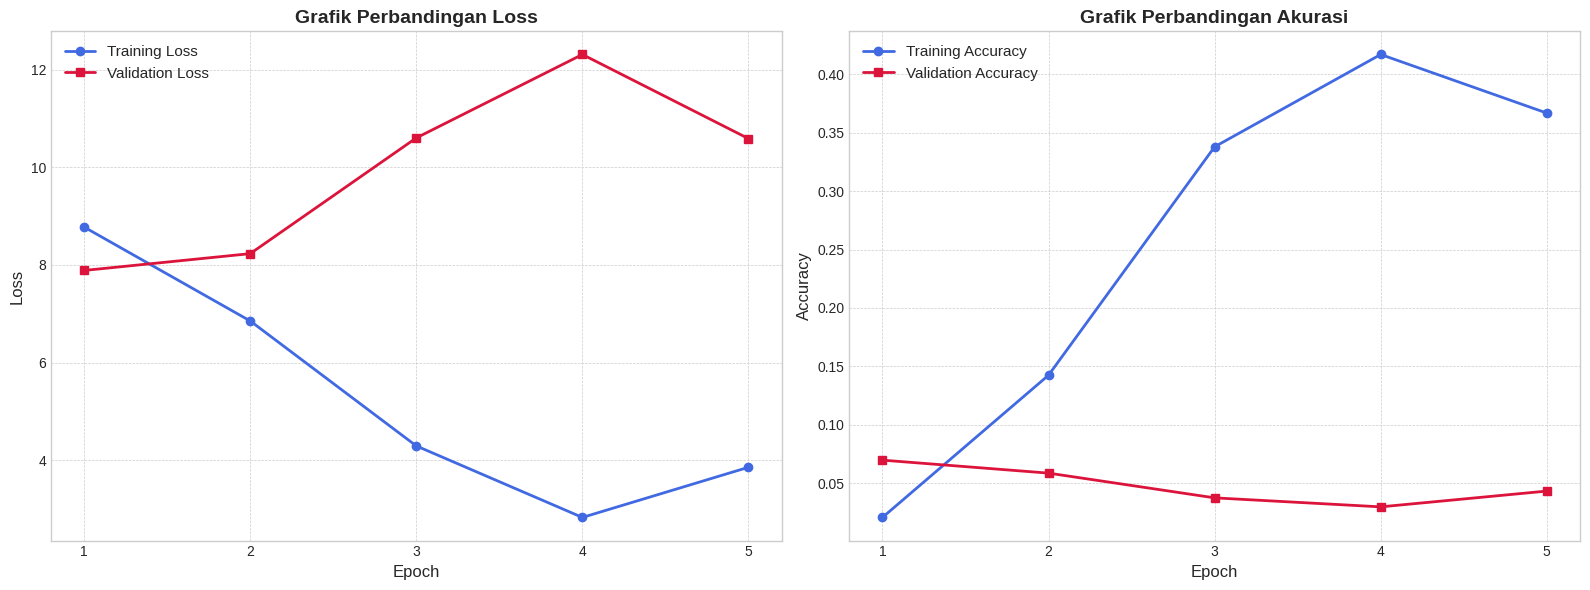

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- 1. Masukkan data dari log training Anda ---
# Data ini diambil langsung dari output training model SimpleRNN + Attention
data = {
    'epoch': [1, 2, 3, 4, 5],
    'loss': [8.7764, 6.8529, 4.2934, 2.8283, 3.8559], # Diambil dari 'loss'
    'start_pointer_accuracy': [0.0222, 0.1241, 0.3174, 0.4220, 0.3610],
    'end_pointer_accuracy': [0.0195, 0.1609, 0.3583, 0.4116, 0.3724],
    'val_loss': [7.8876, 8.2320, 10.6026, 12.3117, 10.5883], # Diambil dari 'val_loss'
    'val_start_pointer_accuracy': [0.0684, 0.0655, 0.0424, 0.0270, 0.0434],
    'val_end_pointer_accuracy': [0.0713, 0.0520, 0.0328, 0.0328, 0.0434]
}

# Buat DataFrame untuk kemudahan
df = pd.DataFrame(data)

# Hitung rata-rata akurasi untuk training dan validation
df['avg_accuracy'] = df[['start_pointer_accuracy', 'end_pointer_accuracy']].mean(axis=1)
df['avg_val_accuracy'] = df[['val_start_pointer_accuracy', 'val_end_pointer_accuracy']].mean(axis=1)


# --- 2. Membuat Plot berdampingan ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(16, 6)) # 1 baris, 2 kolom

# Plot untuk Loss
axes[0].plot(df['epoch'], df['loss'], 'o-', label='Training Loss', color='royalblue', linewidth=2)
axes[0].plot(df['epoch'], df['val_loss'], 's-', label='Validation Loss', color='crimson', linewidth=2)
axes[0].set_title('Grafik Perbandingan Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_xticks(df['epoch'])
axes[0].legend(fontsize=11)
axes[0].grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot untuk Akurasi
axes[1].plot(df['epoch'], df['avg_accuracy'], 'o-', label='Training Accuracy', color='royalblue', linewidth=2)
axes[1].plot(df['epoch'], df['avg_val_accuracy'], 's-', label='Validation Accuracy', color='crimson', linewidth=2)
axes[1].set_title('Grafik Perbandingan Akurasi', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_xticks(df['epoch'])
axes[1].legend(fontsize=11)
axes[1].grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

##Hasil Prediksi

In [ ]:
import numpy as np
import random

# Jumlah sampel yang ingin ditampilkan
NUM_SAMPLES_TO_PREDICT = 5

print("--- Menampilkan Prediksi dari 'attention_model' ---")

# Ambil sampel secara acak dari data validasi yang sudah bersih
# Pastikan jumlah sampel tidak melebihi data yang tersedia
num_available_samples = len(cleaned_val_data)
sample_indices = random.sample(range(num_available_samples), min(NUM_SAMPLES_TO_PREDICT, num_available_samples))

for i, sample_idx in enumerate(sample_indices):
    # 1. Ambil satu sampel data
    sample = cleaned_val_data[sample_idx]
    context_text = sample['context']
    question_text = sample['question']
    true_answer_text = sample['answer']

    # 2. Preprocessing data sampel
    context_tokens_unpadded = tokenizer.texts_to_sequences([context_text])[0]
    question_tokens_unpadded = tokenizer.texts_to_sequences([question_text])[0]

    context_padded = pad_sequences([context_tokens_unpadded], maxlen=MAX_LEN_CONTEXT, padding='post', truncating='post')
    question_padded = pad_sequences([question_tokens_unpadded], maxlen=MAX_LEN_QUESTION, padding='post', truncating='post')

    # 3. Lakukan prediksi
    # Model akan mengembalikan probabilitas untuk start dan end
    start_probs, end_probs = attention_model.predict([context_padded, question_padded], verbose=0)

    # 4. Ambil indeks dengan probabilitas tertinggi
    pred_start_token_idx = np.argmax(start_probs[0])
    pred_end_token_idx = np.argmax(end_probs[0])

    # 5. Konversi token prediksi kembali ke teks
    # Pastikan start index tidak lebih besar dari end index
    if pred_start_token_idx <= pred_end_token_idx:
        predicted_answer_tokens = context_tokens_unpadded[pred_start_token_idx : pred_end_token_idx + 1]
        predicted_answer_text = tokenizer.sequences_to_texts([predicted_answer_tokens])[0]
    else:
        # Jika start > end, prediksi dianggap tidak valid
        predicted_answer_text = "[Prediksi Tidak Valid (start > end)]"

    # Jika tidak ada token yang diprediksi (misal menunjuk ke padding)
    if not predicted_answer_text.strip():
        predicted_answer_text = "[Tidak ada jawaban yang ditemukan]"

    # 6. Tampilkan hasil perbandingan
    print(f"\n--- CONTOH PREDIKSI #{i+1} ---")
    print(f"KONTEKS   : {context_text[:150]}...") # Tampilkan sebagian konteks
    print(f"PERTANYAAN: {question_text}")
    print("-" * 20)
    print(f"JAWABAN ASLI      : {true_answer_text}")
    print(f"JAWABAN PREDIKSI  : {predicted_answer_text}")
    print("=" * 40)

--- Menampilkan Prediksi dari 'attention_model' ---

--- CONTOH PREDIKSI #1 ---
KONTEKS   : Diriwayatkan pula untuk lebih menenangkan hati suaminya, Khadijah mengajak Muhammad mendatangi saudara sepupunya yang juga seorang Nasrani yaitu Waraq...
PERTANYAAN: Siapakah An-Namus al-Akbar yang dimaksud oleh Waraqah?
--------------------
JAWABAN ASLI      : Malaikat Jibril
JAWABAN PREDIKSI  : waraqah bin <unk>

--- CONTOH PREDIKSI #2 ---
KONTEKS   : Pada masa Orde Baru pemerintah sangat mengutamakan persatuan bangsa Indonesia. Setiap hari media massa seperti radio dan televisi mendengungkan slogan...
PERTANYAAN: Apa dampak buruk dari transmigrasi?
--------------------
JAWABAN ASLI      : marjinalisasi
JAWABAN PREDIKSI  : sulawesi timor timur dan irian jaya

--- CONTOH PREDIKSI #3 ---
KONTEKS   : Orang Eurasia, Kamboja, Vietnam, Thai, Minangkabau, Bugis, Jawa, Banjar, Aceh, dan suku-suku asli ikut memperkaya keanekaan penduduk Malaysia. Sejumla...
PERTANYAAN: Apa yang dimaksud dengan bahasa K